In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import time
import matplotlib.pyplot as plt

In [30]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training data into training and validation sets
train_indices, val_indices = train_test_split(np.arange(len(train_dataset)), test_size=0.2, random_state=42)
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DepthwiseSeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(nn.Sequential(
                DepthwiseSeparableConv(in_channels, growth_rate),
                nn.BatchNorm2d(growth_rate),
                nn.ReLU(inplace=True)
            ))
            in_channels += growth_rate

    def forward(self, x):
        for layer in self.layers:
            out = layer(x)
            x = torch.cat([x, out], dim=1)
        return x

In [32]:
class DenseNet(nn.Module):
    def __init__(self, num_classes=10):
        super(DenseNet, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.dense_block1 = DenseBlock(num_layers=4, in_channels=64, growth_rate=32)
        self.transition1 = nn.Sequential(
            nn.Conv2d(64 + 4 * 32, 128, kernel_size=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.dense_block2 = DenseBlock(num_layers=4, in_channels=128, growth_rate=32)
        self.transition2 = nn.Sequential(
            nn.Conv2d(128 + 4 * 32, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.dense_block3 = DenseBlock(num_layers=4, in_channels=256, growth_rate=32)
        self.transition3 = nn.Sequential(
            nn.Conv2d(256 + 4 * 32, 512, kernel_size=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.dense_block4 = DenseBlock(num_layers=4, in_channels=512, growth_rate=32)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 + 4 * 32, num_classes)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.dense_block1(x)
        x = self.transition1(x)
        x = self.dense_block2(x)
        x = self.transition2(x)
        x = self.dense_block3(x)
        x = self.transition3(x)
        x = self.dense_block4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [33]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch 1/100, Train Loss: 1.1820, Val Loss: 0.9408
Epoch 2/100, Train Loss: 0.7565, Val Loss: 0.7013
Epoch 3/100, Train Loss: 0.5801, Val Loss: 0.6236
Epoch 4/100, Train Loss: 0.4657, Val Loss: 0.5575
Epoch 5/100, Train Loss: 0.3829, Val Loss: 0.5962
Epoch 6/100, Train Loss: 0.3115, Val Loss: 0.5891
Epoch 7/100, Train Loss: 0.2536, Val Loss: 0.5779
Epoch 8/100, Train Loss: 0.2045, Val Loss: 0.7472
Epoch 9/100, Train Loss: 0.1609, Val Loss: 0.7298
Epoch 10/100, Train Loss: 0.1354, Val Loss: 0.8437
Epoch 11/100, Train Loss: 0.1226, Val Loss: 0.8943
Epoch 12/100, Train Loss: 0.1046, Val Loss: 0.7128
Epoch 13/100, Train Loss: 0.0998, Val Loss: 0.7402
Epoch 14/100, Train Loss: 0.0915, Val Loss: 0.6790
Epoch 16/100, Train Loss: 0.0771, Val Loss: 0.7721
Epoch 17/100, Train Loss: 0.0650, Val Loss: 0.8011
Epoch 18/100, Train Loss: 0.0697, Val Loss: 1.0831
Epoch 19/100, Train Loss: 0.0646, Val Loss: 0.8670
Epoch 20/100, Train Loss: 0.0585, Val Loss: 0.8851
Epoch 21/100, Train Loss: 0.0559, Val Lo

In [34]:
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

evaluate_model(model, test_loader)

Accuracy: 0.8464
Precision: 0.8464
Recall: 0.8464
F1 Score: 0.8461


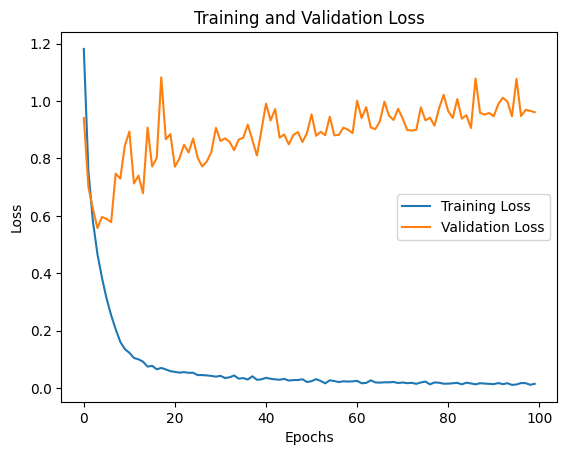

In [35]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [41]:
class TraditionalConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(TraditionalConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [75]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
traditional_model = TraditionalConvNet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(traditional_model.parameters(), lr=0.001)

# Training loop with early stopping
def train_model_with_early_stopping(traditional_model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=5):
    traditional_train_losses, traditional_val_losses = [], []
    best_val_loss = float('inf')  # Initialize best validation loss to infinity
    epochs_no_improve = 0  # Counter for epochs without improvement

    for epoch in range(epochs):
        traditional_model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = traditional_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        train_loss = running_loss / len(train_loader)
        traditional_train_losses.append(train_loss)

        # Validation
        traditional_model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = traditional_model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        traditional_val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0  # Reset the counter
            torch.save(traditional_model.state_dict(), 'best_model.pth')  # Save the best model
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}!")
                break

    # Load the best model weights
    traditional_model.load_state_dict(torch.load('best_model.pth'))
    return traditional_train_losses, traditional_val_losses

# Train the model with early stopping
traditional_train_losses, traditional_val_losses = train_model_with_early_stopping(traditional_model, train_loader, val_loader, criterion, optimizer, epochs=100, patience=5)

Epoch 1/100, Train Loss: 1.2670, Val Loss: 1.0989
Epoch 2/100, Train Loss: 0.9074, Val Loss: 1.3897
Epoch 3/100, Train Loss: 0.7457, Val Loss: 0.8690
Epoch 4/100, Train Loss: 0.6229, Val Loss: 0.9109
Epoch 5/100, Train Loss: 0.5340, Val Loss: 0.6699
Epoch 6/100, Train Loss: 0.4466, Val Loss: 0.6440
Epoch 7/100, Train Loss: 0.3777, Val Loss: 0.6483
Epoch 8/100, Train Loss: 0.3095, Val Loss: 0.7232
Epoch 9/100, Train Loss: 0.2493, Val Loss: 0.9278
Epoch 10/100, Train Loss: 0.2013, Val Loss: 0.9402
Epoch 11/100, Train Loss: 0.1531, Val Loss: 0.6037
Epoch 12/100, Train Loss: 0.1176, Val Loss: 0.9000
Epoch 13/100, Train Loss: 0.0958, Val Loss: 0.8018
Epoch 14/100, Train Loss: 0.0796, Val Loss: 0.6385
Epoch 15/100, Train Loss: 0.0694, Val Loss: 1.2891
Epoch 16/100, Train Loss: 0.0546, Val Loss: 0.6295
Early stopping at epoch 16!


<ipython-input-75-9ef117f52f08>:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  traditional_model.load_state_dict(torch.load('best_model.pth'))


In [76]:
# Evaluate the traditional model
evaluate_model(traditional_model, test_loader)

Accuracy: 0.8109
Precision: 0.8217
Recall: 0.8109
F1 Score: 0.8107


In [78]:
traditional_train_losses

[1.2670481512069702,
 0.9073871898651124,
 0.7456645310878753,
 0.6228973806381226,
 0.5339500638008118,
 0.44661386682987214,
 0.37766278114318846,
 0.3095207818031311,
 0.2492666453242302,
 0.20133349865674974,
 0.15310820463895797,
 0.11759744007289409,
 0.09577810026407242,
 0.07958473138958216,
 0.06943764666542411,
 0.0546153974339366]

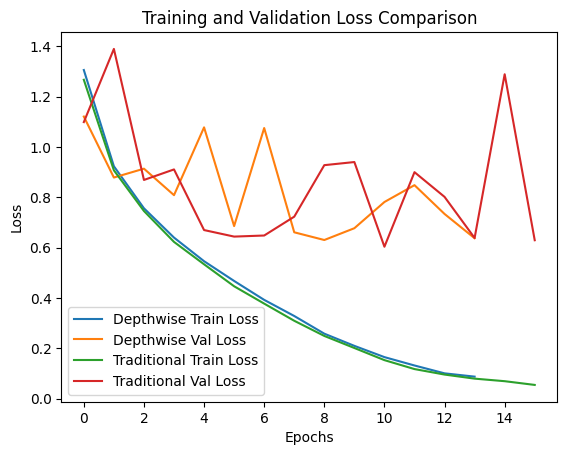

In [77]:
# Plot loss curves
plt.plot(train_losses, label='Depthwise Train Loss')
plt.plot(val_losses, label='Depthwise Val Loss')
plt.plot(traditional_train_losses, label='Traditional Train Loss')
plt.plot(traditional_val_losses, label='Traditional Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Comparison')
plt.legend()
plt.show()

In [89]:
# Function to count parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize models
depthwise_model = DenseNet(num_classes=10).to(device)
traditional_model = TraditionalConvNet(num_classes=10).to(device)

# Count parameters
depthwise_params = count_parameters(denseNet_model)
traditional_params = count_parameters(traditional_model)

# Print parameter counts
print(f"Parameters in DenseNet Model: {denseNet_params}")
print(f"Parameters in Traditional Conv Model: {traditional_params}")

# Calculate percentage reduction
if depthwise_params < traditional_params:
    reduction = ((traditional_params - depthwise_params) / traditional_params) * 100
    print(f"Percentage reduction in parameters: {reduction:.2f}%")
    print("Depth-wise separable model is better in terms of parameter efficiency.")
elif depthwise_params > traditional_params:
    reduction = ((depthwise_params - traditional_params) / depthwise_params) * 100
    print(f"Percentage reduction in parameters: {reduction:.2f}%")
    print("TraditionalConvNet is better in terms of parameter efficiency.")
else:
    print("Both models have the same number of parameters.")

Parameters in DenseNet Model: 492810
Parameters in Traditional Conv Model: 1558026
Percentage reduction in parameters: 68.37%
Depth-wise separable model is better in terms of parameter efficiency.
